In [61]:
import os
import re
import sys
import time
import math
import random
import pickle
from collections import Counter,OrderedDict
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as U
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 0
print(device)

cuda


#####**Download Rotten Tomatoes Dataset and Unzips it** 

In [0]:
!wget https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz

In [5]:
!tar -xvf rt-polaritydata.tar.gz

rt-polaritydata.README.1.0.txt
rt-polaritydata/rt-polarity.neg
rt-polaritydata/rt-polarity.pos


##### **Path to Data and glove embeddings. Change vecpath if glove embeddings are in a different path**

In [0]:
datapath = 'rt-polaritydata/'
vecpath = 'glove.840B.300d.txt'

##### **Comment out first 3 lines if glove embeddings are already downloaded**

In [0]:
!wget https://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip
!rm -rf glove.840B.30d.zip

embedding_index = {}
with open(vecpath,'r',encoding='utf-8') as f:
    for line in f.readlines():
      words = line.split(' ')
      word = words[0]
      v = torch.from_numpy(np.asarray([w for w in words[1:]],'float32'))
      embedding_index[word] = v

##### **Parameters Required to train**

In [0]:
maxlen = 59
embeddim = 300
numclasses = 2
batchsize = 16
epochs = 100

In [0]:
## Preprocess Text taken from Kim CNN preprocessing
def preprocess(text):
  text = str(text)
  text = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", text)     
  text = re.sub(r"\'s", " \'s", text) 
  text = re.sub(r"\'ve", " \'ve", text) 
  text = re.sub(r"n\'t", " n\'t", text) 
  text = re.sub(r"\'re", " \'re", text) 
  text = re.sub(r"\'d", " \'d", text) 
  text = re.sub(r"\'ll", " \'ll", text) 
  text = re.sub(r",", " , ", text) 
  text = re.sub(r"!", " ! ", text) 
  text = re.sub(r"\(", " \( ", text) 
  text = re.sub(r"\)", " \) ", text) 
  text = re.sub(r"\?", " \? ", text) 
  text = re.sub(r"\s{2,}", " ", text)    
  return text.strip().lower()

In [12]:
data = []
poscount = 0
negcount = 0
with open(datapath+'rt-polarity.pos','r',encoding='latin1') as f:
  for line in f.readlines():
    data.append(preprocess(line[:-1]))
    poscount+=1

with open(datapath+'rt-polarity.neg','r',encoding='latin1') as f:
  for line in f.readlines():
    data.append(preprocess(line[:-1]))
    negcount+=1

labels = np.zeros(poscount+negcount)
labels[:poscount] = 1

print("Number of Positive polarity Samples {} ".format(poscount))
print("Number of Negative polarity Samples {} ".format(negcount))


Number of Positive polarity Samples 5331 
Number of Negative polarity Samples 5331 


In [15]:
data,labels = shuffle(data,labels,random_state=0)  ## Shuffle Data for not inducing bias into training data
traindata, testdata, trainlabels, testlabels = train_test_split(data,labels,test_size=0.1,random_state=42)
traindata, valdata, trainlabels, vallabels = train_test_split(traindata,trainlabels,test_size=0.1,random_state=42)
print("Training Data Size: {} ".format(len(traindata)))
print("Validation Data Size: {} ".format(len(valdata)))
print("Testing Data Size: {} ".format(len(testdata)))

Training Data Size: 8635 
Validation Data Size: 960 
Testing Data Size: 1067 


In [0]:
trainlabels = torch.from_numpy(trainlabels)  # Converting Numpy Labels to Torch Labels
vallabels = torch.from_numpy(vallabels)
testlabels = torch.from_numpy(testlabels)

##### **Takes list of sentences as argument an returns vocabulary**

In [0]:
def get_vocab(corpus):
  words = []
  for sentence in corpus:
    words+=sentence.split()
  counts = Counter(words).most_common()
  counts.insert(0,('<PAD>',0)) ## Index 0 for PAD word
  counts.insert(1,('<UNK>',1))  ## Index 1 for OOV word
  vocabulary = {}
  vocabulary = {word:i for i,(word,_) in enumerate(counts)}
  return vocabulary

In [22]:
vocab = get_vocab(traindata)
print("Vocabulary Size is :",len(vocab))

Vocabulary Size is : 17013


##### **Converts each sentences to corresponding Indices in vocabulary**

In [0]:
def get_vectors(sentence,vocabulary):
  temp = [vocabulary[word] for word in sentence.split() if word in vocabulary]
  vector = [0] * maxlen   ## Pads the sentence to maxlen
  curlen = len(temp)
  if(maxlen-curlen<0):
      vector = temp[:maxlen]
  else:
      vector[maxlen-curlen:] = temp

  return torch.from_numpy(np.asarray(vector,dtype='int32'))

In [0]:
def get_data(data,vocabulary):
  vectors = torch.zeros(len(data),maxlen)
  for i in range(len(data)):
      vectors[i] = get_vectors(data[i],vocabulary)
  return vectors

In [0]:
trainindices = get_data(traindata,vocab)  ## Training data Indices
valindices = get_data(valdata,vocab)    ## Validation data Indices
testindices = get_data(testdata,vocab)   ## Testing data Indices

In [31]:
trainindices.size(),valindices.size(),testindices.size()

(torch.Size([8635, 59]), torch.Size([960, 59]), torch.Size([1067, 59]))

In [0]:
trainarray = U.TensorDataset(trainindices,trainlabels)
trainloader = U.DataLoader(trainarray,batch_size=batchsize)  ## Train Loader 

valarray = U.TensorDataset(valindices,vallabels)
valloader = U.DataLoader(valarray,batch_size=batchsize) ## Validation Loader 

testarray = U.TensorDataset(testindices,testlabels)
testloader = U.DataLoader(testarray,batch_size=batchsize) ## Test Loader 

In [34]:
len(trainloader),len(valloader),len(testloader)

(540, 60, 67)

In [0]:
embedding_matrix = torch.zeros(len(vocab),embeddim).to(device)
for i,word in enumerate(vocab):
  embedding_vector = embedding_index.get(word)
  if(embedding_vector is not None):
    embedding_matrix[i] = embedding_vector
  elif(word!='<PAD>'):
    embedding_matrix[i] = torch.from_numpy(np.random.normal(0,0.1,embeddim)) 

In [36]:
embedding_matrix.size()

torch.Size([17013, 300])

In [0]:
class LayerNorm(nn.Module):
  def __init__(self,size,epsilon=1e-8):
    super(LayerNorm,self).__init__()
    self.alpha = nn.Parameter(torch.ones(size))   ## Alpha
    self.biass = nn.Parameter(torch.zeros(size))  ## Bias
    self.epsilon = epsilon
  
    self.register_parameter('alpha',self.alpha)
    self.register_parameter('biass',self.biass)

  def forward(self,x):
    x_mean = torch.mean(x,-1,keepdim=True)  ## Mean of Tensor along last dimension
    x_std = x.std(-1,keepdim=True)     ## STD of Tensor along last dimension

    x_norm = (x - x_mean)/(x_std + self.epsilon)  ## Normalization
    x_norm = x_norm * self.alpha + self.biass  ## Normalized Tensor
    return x_norm

In [0]:
hidden1 = 200
hidden2 = 100

In [0]:
class ModelwithNorm(nn.Module):
  def __init__(self):
    super(ModelwithNorm,self).__init__()
    self.hiddendim1 = hidden1
    self.hiddendim2 = hidden2
    self.maxlen = maxlen
    self.embeddim = embeddim
    self.numclasses = numclasses
    self.embed = nn.Embedding.from_pretrained(embedding_matrix,freeze=False)
    self.lstm1 = nn.LSTM(self.embeddim,self.hiddendim1,batch_first=True)
    self.lstm2 = nn.LSTM(self.hiddendim1,self.hiddendim2,batch_first=True)
    self.fc = nn.Linear(self.hiddendim2,numclasses)
    self.ln1 = LayerNorm(self.hiddendim1)   ## Layer Norm on First LSTM
    self.ln2 = LayerNorm(self.hiddendim2)   ## Layer Norm on Second LSTM

  def forward(self,x):
    x = self.embed(x)
    out,_ = self.lstm1(x)
    out = self.ln1(out)
    out,_ = self.lstm2(out)
    out = self.ln2(out)
    out = self.fc(out[:,-1,:])
    return out

In [0]:
model1 = ModelwithNorm().to(device)

In [123]:
p = torch.ones([3,maxlen]).long().to(device)
outp = model1(p)
print(outp.size())

torch.Size([3, 2])


In [0]:
class ModelwithoutNorm(nn.Module):
  def __init__(self):
    super(ModelwithoutNorm,self).__init__()
    self.hiddendim1 = hidden1
    self.hiddendim2 = hidden2
    self.maxlen = maxlen
    self.embeddim = embeddim
    self.numclasses = numclasses
    self.embed = nn.Embedding.from_pretrained(embedding_matrix,freeze=False)
    self.lstm1 = nn.LSTM(self.embeddim,self.hiddendim1,batch_first=True)
    self.lstm2 = nn.LSTM(self.hiddendim1,self.hiddendim2,batch_first=True)
    self.fc = nn.Linear(self.hiddendim2,numclasses)

  def forward(self,x):
    x = self.embed(x)
    out,_ = self.lstm1(x)
    out,_ = self.lstm2(out)
    out = self.fc(out[:,-1,:])
    return out

In [0]:
model2 = ModelwithoutNorm().to(device)

In [126]:
outp = model2(p)
print(outp.size())

torch.Size([3, 2])


In [0]:
def evaluate(model,loader):
  curloss = 0.0
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for indices,labels in loader:
      indices = indices.long().to(device)
      labels = labels.long().to(device)

      total+=indices.size(0)
      output = model(indices)
      loss = F.cross_entropy(output,labels,reduction='sum')
      curloss+=loss.item()
      output = torch.max(output,1)[1]
      correct+=torch.sum(labels==output).item()

    return round((curloss/total),3),round(((correct/total)*100),2)

In [142]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model1 = ModelwithNorm().to(device)
optim1 = optim.SGD(model1.parameters(),lr=0.01,momentum=0.9)

model2 = ModelwithoutNorm().to(device)
optim2 = optim.SGD(model2.parameters(),lr=0.01,momentum=0.9)

model1trainloss = []  # Layer Norm Model Train Loss
model2trainloss = []  # No Norm Model Train Loss
model1trainacc = []   # Layer Norm Model Train Accuracy
model2trainacc = []   # No Norm Model Train Accuracy
model1valloss = []   # Layer Norm Model val Loss
model2valloss = []   # No Norm Model val Loss
model1valacc = []   # Layer Norm Model Val Accuracy
model2valacc = []  # No Norm Model Val Accuracy

patience = 10    ## Early Stopping Patience
curpatience = patience

print("Training Model with Layer Normalization ")
print("--------------------------------------------------------------------")
best_model_wts = deepcopy(model1.state_dict())
bestvalloss = np.Inf
model1.train()
steps1 = 0
epochs1 = 0
for epoch in range(1,epochs+1):
  model1.train()
  curtrainloss = 0.0
  for trainindices,trainlab in trainloader:
    trainindices,trainlab = trainindices.long().to(device),trainlab.long().to(device)
    model1.zero_grad()
    output = model1(trainindices)
    loss = F.cross_entropy(output,trainlab,reduction='mean')
    loss.backward()
    optim1.step()
    model1trainloss.append(loss.item())
    curtrainloss+=loss.item()
    steps1+=1
  epochs1+=1
  _, curtrainacc = evaluate(model1,trainloader)
  curvalloss,curvalacc = evaluate(model1,valloader)
  print("Epoch {} Train Loss {} Train Accuracy {} ".format(epoch,round(curtrainloss/len(trainloader),3),curtrainacc))
  print("Validation Loss {} Validation Accuracy {} ".format(curvalloss,curvalacc))
  print("-----------------------------------------------------------------------------------")
  model1valloss.append(curvalloss)
  model1valacc.append(curvalacc)
  if(curvalloss<bestvalloss):
    bestvalloss = curvalloss
    best_model_wts = deepcopy(model1.state_dict())
    curpatience = patience
  else:
    curpatience = curpatience - 1
    if(curpatience==0): # Early Stopping
      break

model1 = ModelwithNorm().to(device)
model1.load_state_dict(best_model_wts)
testloss,testacc = evaluate(model1,testloader)
print("Test Accuracy (With Layer Normalization) {} ".format(testacc))
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("Training Model without Layer Normalization ")
print("--------------------------------------------------------------------")
curpatience = patience
best_model_wts = deepcopy(model2.state_dict())
bestvalloss = np.Inf
steps2 = 0
epochs2 = 0
model2.train()
for epoch in range(1,epochs+1):
  model2.train()
  curtrainloss = 0.0
  for trainindices,trainlab in trainloader:
    trainindices,trainlab = trainindices.long().to(device),trainlab.long().to(device)
    model2.zero_grad()
    output = model2(trainindices)
    loss = F.cross_entropy(output,trainlab,reduction='mean')
    loss.backward()
    optim2.step()
    model2trainloss.append(loss.item())
    curtrainloss+=loss.item()
    steps2+=1
  epochs2+=1
  _, curtrainacc = evaluate(model2,trainloader)
  curvalloss,curvalacc = evaluate(model2,valloader)
  print("Epoch {} Train Loss {} Train Accuracy {} ".format(epoch,round(curtrainloss/len(trainloader),3),curtrainacc))
  print("Validation Loss {} Validation Accuracy {} ".format(curvalloss,curvalacc))
  print("-----------------------------------------------------------------------------------")
  model2valloss.append(curvalloss)
  model2valacc.append(curvalacc)
  if(curvalloss<bestvalloss):
    bestvalloss = curvalloss 
    best_model_wts = deepcopy(model2.state_dict())
    curpatience = patience
  else:
    curpatience = curpatience - 1
    if(curpatience==0):
      break

model2 = ModelwithoutNorm().to(device)
model2.load_state_dict(best_model_wts)
testloss,testacc = evaluate(model2,testloader)
print("Test Accuracy (Without Layer Normalization) {} ".format(testacc))

Training Model with Layer Normalization 
--------------------------------------------------------------------
Epoch 1 Train Loss 0.209 Train Accuracy 96.34 
Validation Loss 0.607 Validation Accuracy 79.48 
-----------------------------------------------------------------------------------
Epoch 2 Train Loss 0.105 Train Accuracy 97.57 
Validation Loss 0.731 Validation Accuracy 79.27 
-----------------------------------------------------------------------------------
Epoch 3 Train Loss 0.067 Train Accuracy 97.68 
Validation Loss 0.743 Validation Accuracy 78.44 
-----------------------------------------------------------------------------------
Epoch 4 Train Loss 0.059 Train Accuracy 98.38 
Validation Loss 1.002 Validation Accuracy 78.85 
-----------------------------------------------------------------------------------
Epoch 5 Train Loss 0.045 Train Accuracy 97.12 
Validation Loss 1.341 Validation Accuracy 76.25 
--------------------------------------------------------------------------

In [0]:
steps = list(range(min(steps1,steps2)))   ## Minimum steps for Both models
iterations = list(range(min(epochs1,epochs2))) ## Minimum Epochs before early stopping

##### **Plot Training Loss for Both the models**

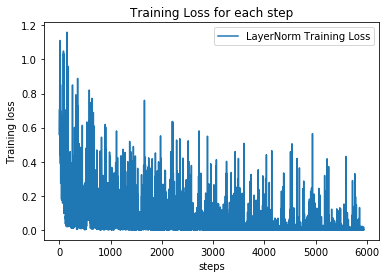

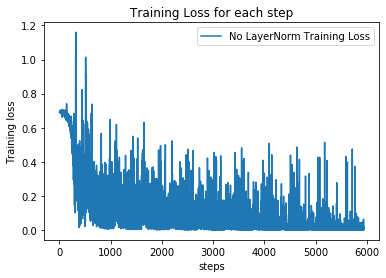

In [144]:
plt.plot(steps,model1trainloss[:len(steps)],label='LayerNorm Training Loss')
plt.title('Training Loss for each step')
plt.ylabel('Training loss')
plt.xlabel('steps')
plt.legend()
plt.show()

plt.plot(steps,model2trainloss[:len(steps)],label='No LayerNorm Training Loss')
plt.title('Training Loss for each step')
plt.ylabel('Training loss')
plt.xlabel('steps')
plt.legend()
plt.show()

##### **Plot Validation Loss for Both the models**

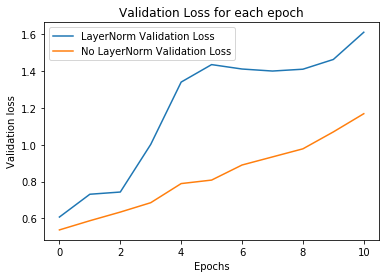

In [145]:
plt.plot(iterations,model1valloss[:len(iterations)],label='LayerNorm Validation Loss')
plt.plot(iterations,model2valloss[:len(iterations)],label='No LayerNorm Validation Loss')
plt.title('Validation Loss for each epoch')
plt.ylabel('Validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

##### **Plot Validation Accuracy for Both the models**

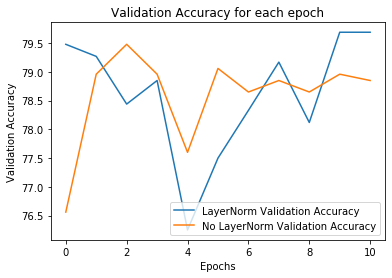

In [146]:
plt.plot(iterations,model1valacc[:len(iterations)],label='LayerNorm Validation Accuracy')
plt.plot(iterations,model2valacc[:len(iterations)],label='No LayerNorm Validation Accuracy')
plt.title('Validation Accuracy for each epoch')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

###### **Conclusion:**
###### Clearly Layer Normalization showed better performance than when no normalization is applied on LSTM
##### 1. LayerNorm achieved good performance in fewer training steps.
##### 2. Training Loss constantly decreased across training steps.
##### 3. Time required to train is also very less